In [1]:
"""
🧬 Breast Cancer Detection using Stacking Ensemble
-------------------------------------------------
Author: Satyam Kumar
Description:
A powerful stacking ensemble model combining CatBoost, XGBoost, and LightGBM
with Random Forest as the meta-learner to classify tumors as benign or malignant.
"""
# ===============================================================
# 📦 Import Libraries
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pickle



In [2]:
# Load and Prepare Data
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df["target"] = cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
# Splint Data
x = df.drop("target", axis=1)
y = df["target"]

In [11]:
# Spliting Training and Testing Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [12]:
# Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [13]:
# Defining Cross-Validation Strategy
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Model 1: Random Forest (Meta Model)
rf = RandomForestClassifier(random_state=42,class_weight="balanced")
param_grid = {
    "max_depth":[2,3,4,5],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[2,4,6],
    "n_estimators":[100,150,200]
}
grid_rf = RandomizedSearchCV(rf,param_grid,cv=sk,n_iter=4,n_jobs=-1,scoring="roc_auc",random_state=42)
grid_rf.fit(x_res,y_res)
print(grid_rf.best_score_)
best_rf = grid_rf.best_estimator_

0.9939886012672334


In [9]:
# Model 2: XGBoost 
xgb = XGBClassifier(random_state=42,eval_metric="logloss",use_label_encoder=False)
param_grid = {
    "n_estimators":[100,150,200],
    "max_depth":[3,4,5],
    "learning_rate":[0.1,0.01,0.5,0.05],
    "colsample_bytree":[0.6,0.7,0.8,0.9],
    "subsample":[0.6,0.7,0.8,0.9],
    "gamma":[0.6,0.7,0.8,0.9],
    "reg_lambda":[1,2,3],
    "reg_alpha":[0.8,1]
}
grid_xgb = RandomizedSearchCV(xgb,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc",
n_iter=20,random_state=42)
grid_xgb.fit(x_res,y_res)
print(grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_

0.9932615871196443


In [17]:
# Model 3: CatBoost
cat = CatBoostClassifier(eval_metric="AUC",random_seed=42,verbose=0)
param_grid = {
    "iterations":[500,800,100],
    "learning_rate":[0.1,0.5,0.01,0.05],
    "depth":[4,5,6]
}
grid_cat = RandomizedSearchCV(cat,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc"
,n_iter=20,random_state=42)
grid_cat.fit(x_res,y_res)
print(grid_cat.best_score_)
best_cat = grid_cat.best_estimator_

0.9956018297407159


In [18]:
# Model 4: LightBoost
lgb = LGBMClassifier(random_state=42,verbose=0)
param_grid = {
    "max_depth":[2,3,4,5],
    "n_estimators":[100,150,200],
    "learning_rate":[0.1,0.01,0.5,0.05]

}
grid_lgb = RandomizedSearchCV(lgb,param_grid,cv=sk,n_iter=20,scoring="roc_auc",n_jobs=-1,random_state=42)
grid_lgb.fit(x_res,y_res)
print(grid_lgb.best_score_)
best_lgb = grid_lgb.best_estimator_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [19]:
# Build Stacking Ensemble
base_model = [
    ("cat",best_cat),
    ("xgb",best_xgb),
    ("lgb",best_lgb)
]

meta_model = best_rf
stack = StackingClassifier(
    estimators=base_model,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
   
)
stack.fit(x_res, y_res)

StackingClassifier(cv=5,
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000023F12D41C70>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_w...
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=150, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgb',
                                LGBMClassifier(learning_rate=0.5, max_depth=3,
                                               random_state=42, verbose=0))],
                   final_estimator=RandomForestClassifier(class_weight='balanced',
                                                          max_depth=5,
                                                          min_samples_leaf=2,
                                                          n_estimators=200,
                                                          random_state=42),
                   n_jobs=-1, passthrough=True)

In [20]:
# Model Evaluation
y_pred = stack.predict(x_test)
y_proba = stack.predict_proba(x_test)[:, 1]
print("\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



--- Model Evaluation ---
Test Accuracy: 0.9825
ROC-AUC Score: 0.9957

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[41  2]
 [ 0 71]]


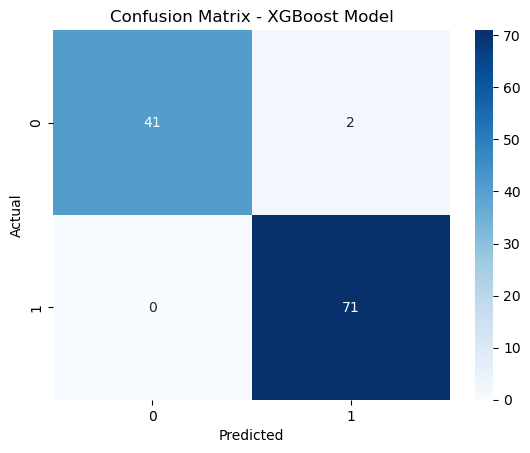

In [18]:
# Confusion Matrix Plot
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()


In [19]:
# Cross Validation
cv_score = cross_val_score(stack, x, y, cv=sk, scoring="roc_auc", n_jobs=-1)
print(f"\nMean Cross-Validation ROC-AUC: {cv_score.mean():.4f}")


Mean Cross-Validation ROC-AUC: 0.9907


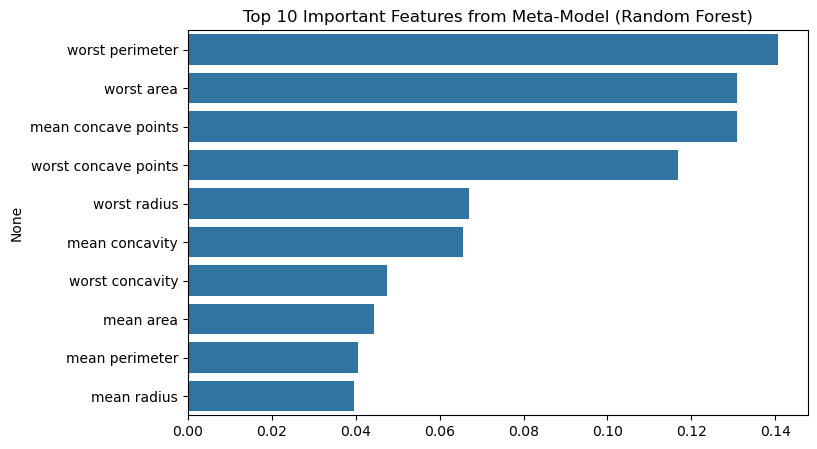

In [20]:
# 📊 Feature Importance (Optional)
# ===============================================================
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=x.columns).sort_values(ascending=False)[:10]

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Important Features from Meta-Model (Random Forest)")
plt.show()